# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

In [16]:
# from sklearn.datasets import load_boston датасет удален

Датасет Бостон был удален из sklearn, поэтому я скачал его из kaggle: https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset/data

In [2]:
# column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston = pd.read_csv('housing.csv', header=None, delimiter=r"\s+")  # names=column_names

In [3]:
boston.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
# X = boston["data"]
# y = boston["target"]

# feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']  # все кроме MEDV

X = np.array(boston.iloc[:, :-1])
y = np.array(boston.iloc[:, -1])

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [12]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.18499790439587

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [13]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    # инициализируем контейнеры и векторы 
    sum_of_preds = np.zeros(X.shape[0], dtype=float)
    count_of_preds = np.zeros(X.shape[0], dtype=int)
    all_mse = []
    all_preds_by_index = np.empty(X.shape[0], dtype=object)

    # для каждой из бутстр. подвыборок
    for j in range(num_runs):
        # получаем выборку
        idx = np.random.uniform(0, X.shape[0], size=X.shape[0]).astype(int)
        oob = np.ones(X.shape[0], dtype=bool)
        oob[idx] = False
        # обучаем алгоритм
        regressor.fit(X[idx, :], y[idx, ])
        # считаем предсказания по out-of-bag
        preds = regressor.predict(X[oob, :])
        sum_of_preds[oob] += preds  # складываем предсказания
        count_of_preds[oob] += 1    # фиксируем, что мы обучились на этом объекте
        
        # собираем все предсказания для каждого объекта по отдельности (не суммой)
        all_preds_by_index[oob] = list((map(lambda x, y: np.append(arr=x, values=y) if not x is None else y, all_preds_by_index[oob], preds)))
        # складываем сумму квадартов по j выборке
        all_mse += [np.mean((y[oob] - preds)**2)]
    
    # считаем средний лосс
    loss = np.mean(all_mse)
    # считаем дисперсию предсказаний по тем объектам, которые попадали в OOB
    std_preds = list(map(lambda x: np.std(x)**2, list(filter(None.__ne__, all_preds_by_index)))) 
    mean_var = np.mean(std_preds)
    # среднее среднее предсказание алгоритма для bias
    mean_oob = np.divide(sum_of_preds, count_of_preds, where=count_of_preds!=0)
    substract = np.subtract(y, mean_oob, where=mean_oob!=0)
    bias_by_objects = substract**2
    sum_non_zero_counts_bias = np.mean(bias_by_objects, where=count_of_preds!=0)
    total_bias = sum_non_zero_counts_bias
    return total_bias, mean_var, loss
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [150]:
np.random.seed(13)
bias, variance, loss = compute_biase_variance(LinearRegression(), X, y)

print(f'Bias = {bias}, \nVariance = {variance}, \nLoss = {loss}')

Bias = 23.749069735314134, 
Variance = 0.9651415000556302, 
Loss = 24.739558580232167


In [151]:
np.random.seed(13)
bias, variance, loss = compute_biase_variance(DecisionTreeRegressor(), X, y)

print(f'Bias = {bias}, \nVariance = {variance}, \nLoss = {loss}')

Bias = 10.306947473266431, 
Variance = 13.097894493569813, 
Loss = 23.49468803858415


In [152]:
np.random.seed(13)
bias, variance, loss = compute_biase_variance(RandomForestRegressor(), X, y)

print(f'Bias = {bias}, \nVariance = {variance}, \nLoss = {loss}')

Bias = 10.618453118263389, 
Variance = 2.2383550411041755, 
Loss = 12.870425636507163


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ да, результаты согласуются. Линейной модели действительно свойственено большое смещение, но низкий разброс; у решающего дерева (глубокого) смещение низкое, но разброс сильно выше (сильно переобучается). Случайный лес берет все сильное от реш. деревьев и борется с минусами: у него такое же низкое смещение, но разброс тоже низкий (почти как у линейной модели). Ровно как мы говорили на лекции / семинаре. При этом общая ошибка (loss) действительно везде получается как сумма смещения и разброса с большой точностью.

Получилось как раз мы вывели на лекции:
<img src="https://www.dropbox.com/s/5a5ubvrhgfmga7n/photo1.png?dl=1" align="right" width="40%" style="margin-left: 20px; margin-bottom: 20px">
<img src="https://www.dropbox.com/s/akbqloak44dvf16/photo2.png?dl=1" align="right" width="40%" style="margin-left: 20px; margin-bottom: 20px">

*да, я веду конспекты от руки.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [154]:
np.random.seed(13)
bias, variance, loss = compute_biase_variance(BaggingRegressor(LinearRegression()), X, y)

print(f'Bias = {bias}, \nVariance = {variance}, \nLoss = {loss}')

Bias = 23.72697698724097, 
Variance = 1.0490011331320703, 
Loss = 24.976494754677034


In [155]:
np.random.seed(13)
bias, variance, loss = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y)

print(f'Bias = {bias}, \nVariance = {variance}, \nLoss = {loss}')

Bias = 10.784571137422411, 
Variance = 3.3977346508274753, 
Loss = 14.332735562866038


In [156]:
np.random.seed(13)
bias, variance, loss = compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y)

print(f'Bias = {bias}, \nVariance = {variance}, \nLoss = {loss}')

Bias = 11.746738881477839, 
Variance = 1.4135991016544982, 
Loss = 13.332335718729839


__Your answer here:__ из лекции: $$bias(a_N) = bias(b_n)$$ и $$Var(a_N) = \dfrac{1}{N} Var(b_n) + const \times Cov(b_n(x), \ b_m(x))$$

То есть, в теории, смещение композиции бэггинга такое же, как у базовой модели, а разброс меньше в N раз (N - число базовых моделей) при условии, что модели нескоррелированы между собой. То есть в качестве базовых моделей нужно брать сложные и несвязанные между собой модели.

Следовательно, бэггинг над линейными регрессиями бесполезен: смещение и разброс почти такие же, одной модели было вполне достаточно для такого же результата. Дерево осталось таким же мощным (низкое смещение), разброс тоже сократился, но не так сильно, как у одного случайного леса: это логично, т.к. отдельные деревья по умолчанию все-таки сильно связаны друг с другом.
У леса немного выросло смещение и немного сократился разброс (в целом ошибка выросла). Но он считался непозволительно долго, да и случайный лес - сама по себе композиция, поэтому это довольно странная операция, ухудшающая качество (слишком много случайностей). Как ожидалось, самая полезная композиция - между решающими деревьями (по сути, недо-случайный лес)

В целом, получилось примерно как на двух картинках выше из конспекта.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

На всякий случай, вот мишень для удобства:

<img src="https://www.dropbox.com/s/v12akzzcq29qu4s/photo3.png?dl=1" align="center" width="40%" style="margin-left: 20px; margin-bottom: 20px">

In [15]:
import seaborn as sns
sns.set(style='darkgrid', palette='deep')

plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects/X.shape[0], random_state=13, shuffle=True)
    
    for j in range(num_runs):
        idx = np.random.uniform(0, X_train.shape[0], size=X_train.shape[0]).astype(int)
        regressor.fit(X_train[idx, :], y[idx, ])
        preds = regressor.predict(X_test)
        plt.scatter(range(num_test_objects), preds, c=range(num_test_objects), cmap=sns.color_palette("Spectral", as_cmap=True))
    plt.scatter(range(num_test_objects), y_test, c='black')
    plt.ylabel('Предсказания модели на \nодном объекте')
    plt.xlabel('Номер объекта в тестовой выборке')
    plt.xticks(range(num_test_objects))
    plt.title(title, fontsize=15)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

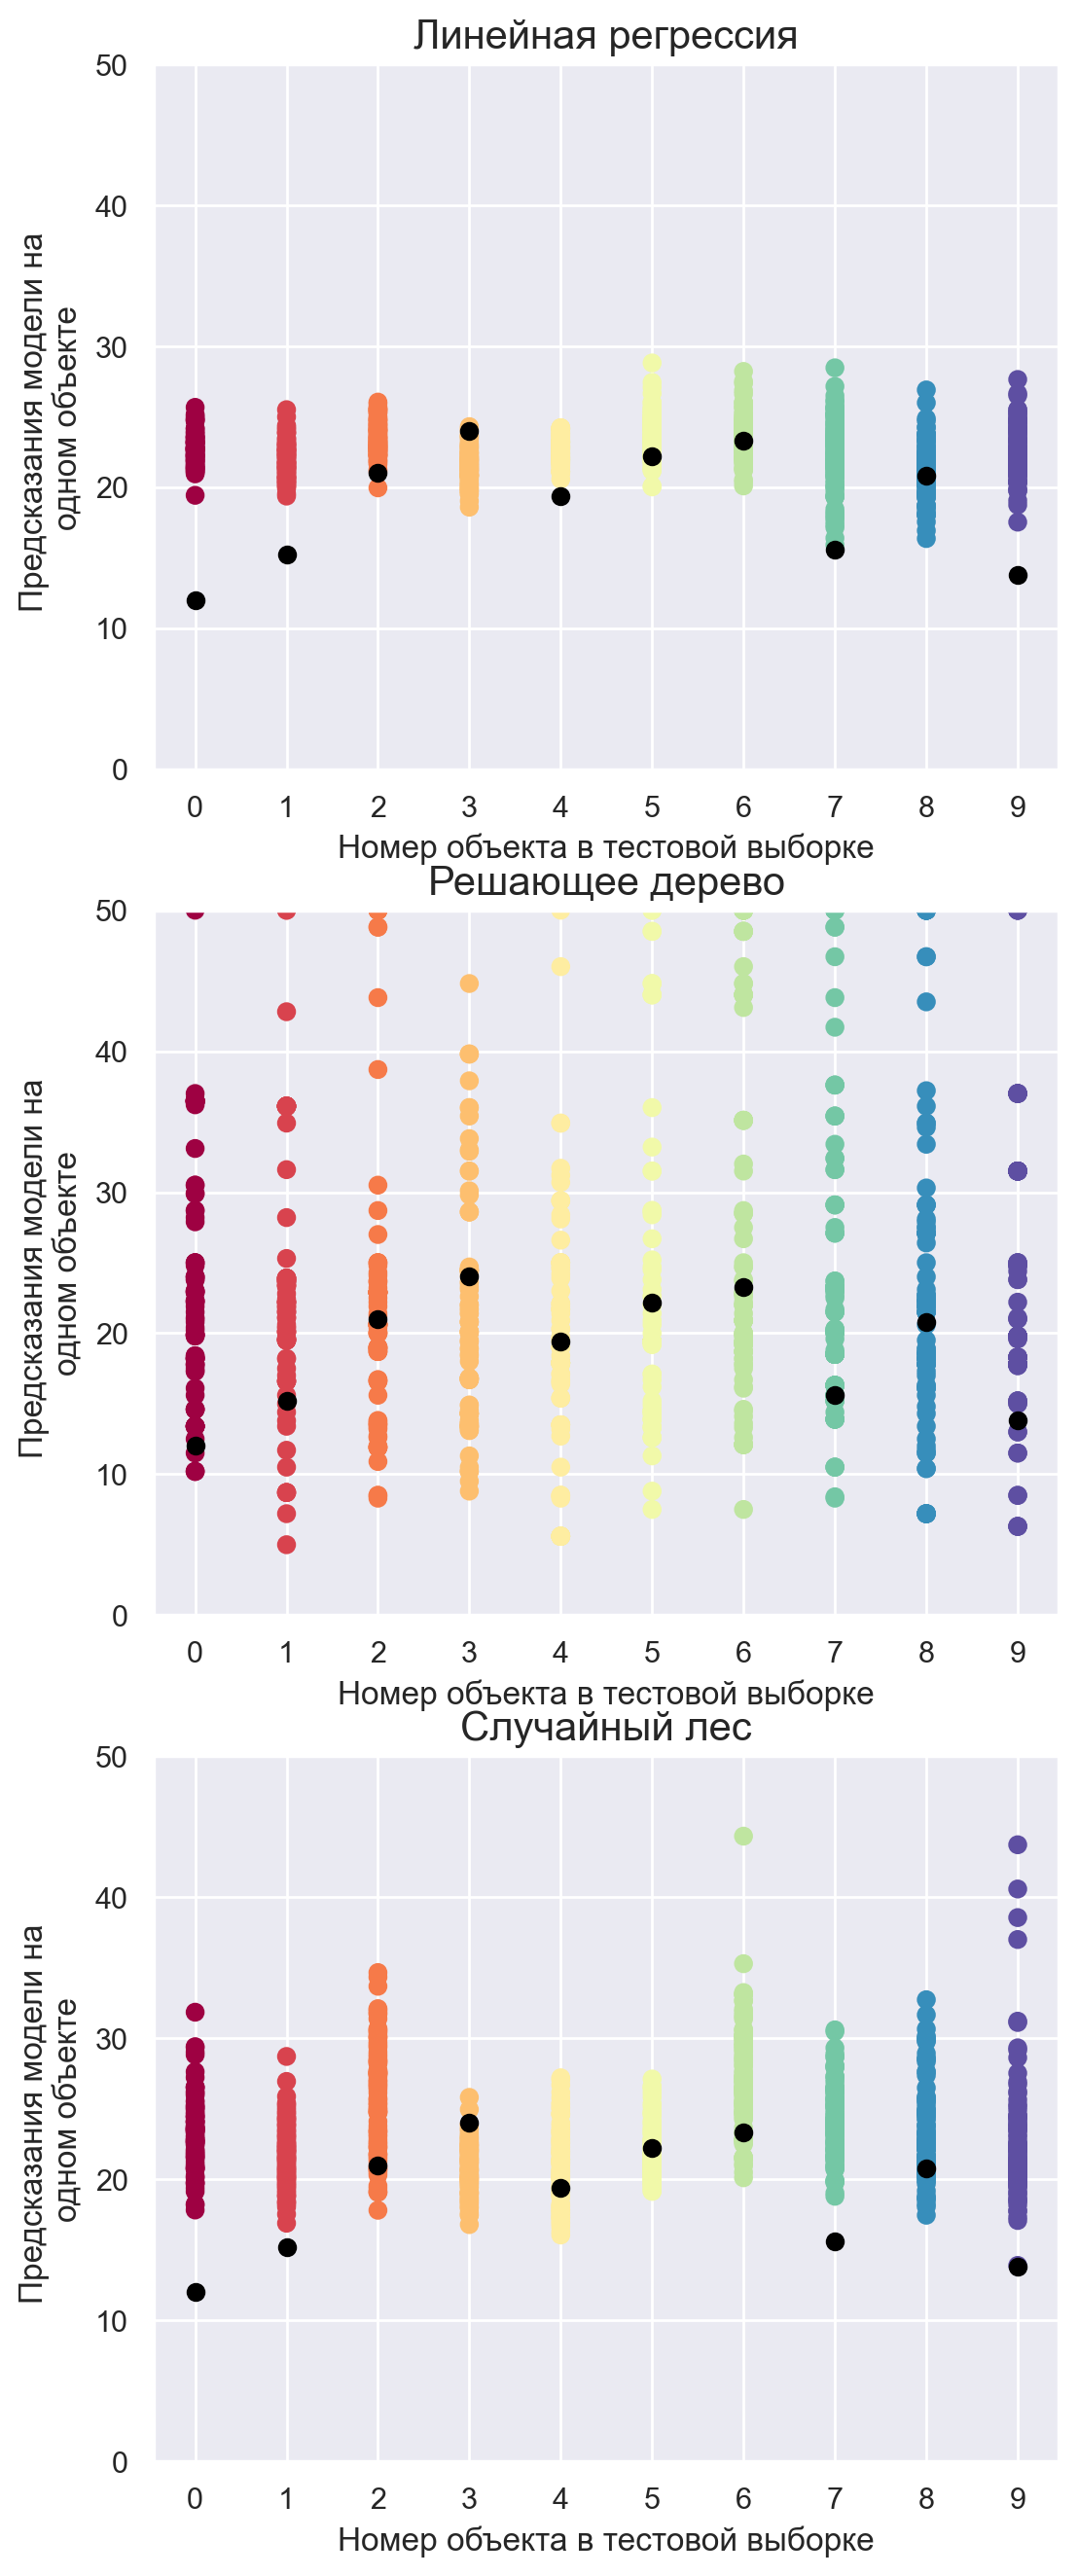

In [28]:
np.random.seed(13)

plt.figure(figsize=(6, 16))

plt.subplot(3, 1, 1)
plot_predictions(LinearRegression(), X, y, title='Линейная регрессия')
plt.ylim(0, 50)

plt.subplot(3, 1, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title='Решающее дерево')
plt.ylim(0, 50)

plt.subplot(3, 1, 3)
plot_predictions(RandomForestRegressor(), X, y, title='Случайный лес')
plt.ylim(0, 50)

plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

1. Отлично видны главные характеристики **линейной регрессии**, особенно на фоне других графиков: очень маленький разброс и большое смещение. Однако, несмотря на то, что модель сильно ошибается на 3 объектах (истинные метки не входят в предсказания), мне кажется, что в этом конкретном примере она показывает себя довольно неплохо (насколько я помню, в данном датасете зависимость таргета действительно линейная). Хорошо видно, насколько "кучно" бьет линейная регрессия. Хотя, возможно, нам повезло с тестовыми объектами, ведь, в среднем, смещение было большое.

2. **Решающее дерево** тоже отлично показывает свои свойства: очень большой разброс (буквально от минимальных до максимальных значений в выборке), но, при этом, маленькое смещение среднего алгоритма: какие-то предсказания хотя бы раз точно были верными, да и, в среднем, мы ошибаемся тоже меньше. Здесь можно заметить логику дальшейшей композиции над реш. дер.: средние предсказания неплохо предсказывают истинный таргет.

3. **Случайный лес** - что-то среднее между LR и DT. Смещение среднего алгоритма явно меньше, но разброс - все еще больше, чем у линейной регрессии. При этом интересно, что на некоторых объектах (8, 6) результаты линейной регрессии были лучше: видимо, там действительно линейная взаимосвязь.

Наверное, если бы не фиксирование оси Y, разница действительно была бы не так заметна.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

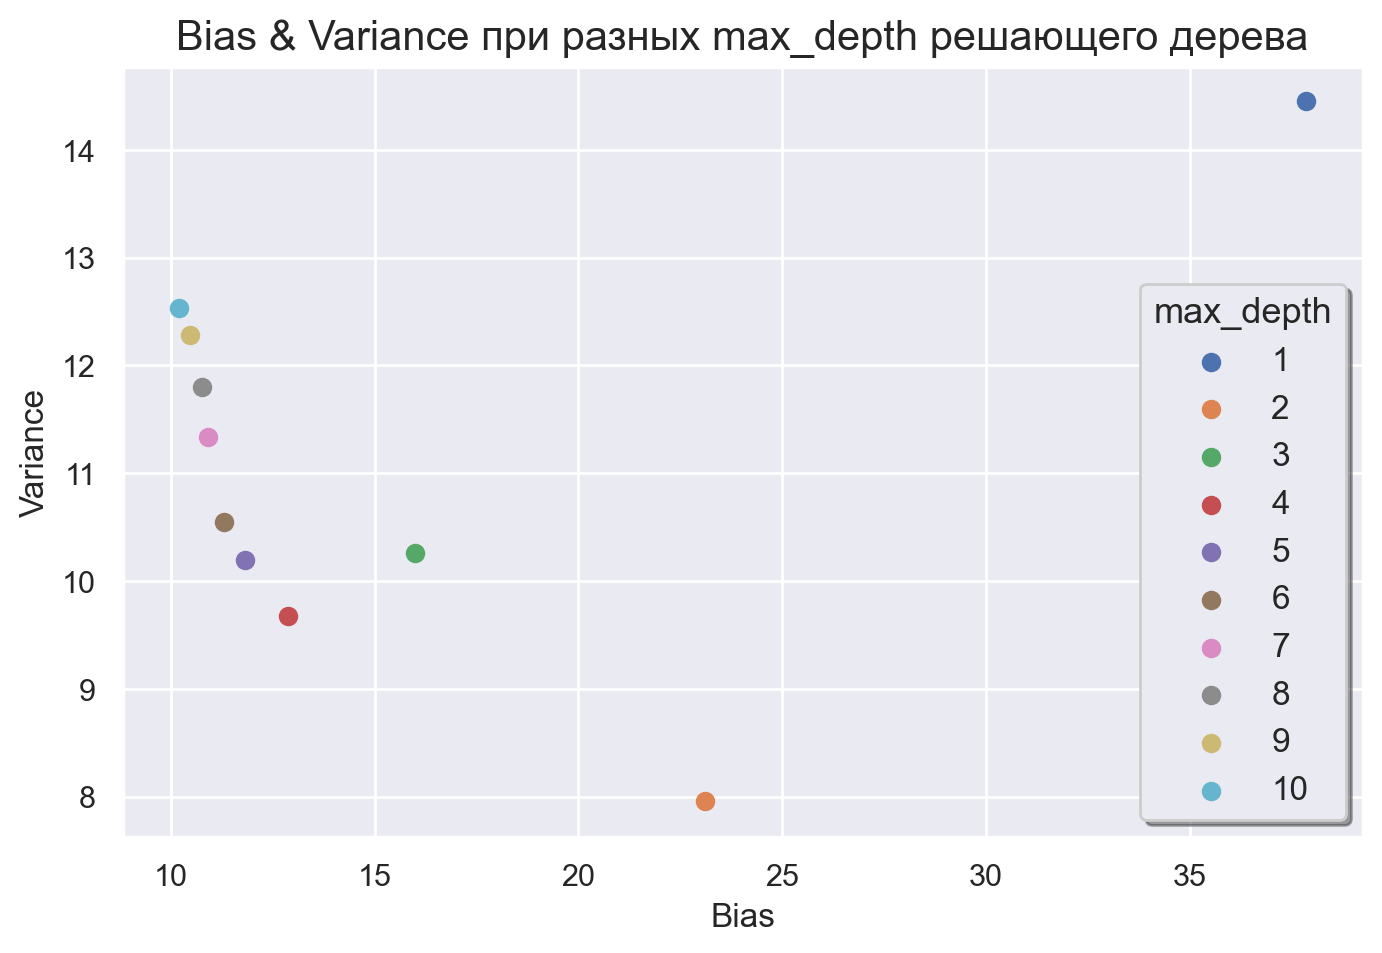

In [34]:
# тестим max_depth
plt.figure(figsize=(8, 5))

for max_depth in range(1, 11):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
    plt.scatter(bias, variance, label = str(max_depth), cmap=sns.color_palette("Spectral", as_cmap=True))

plt.legend(title='max_depth', title_fontsize=13, fontsize=12, loc='best', shadow=True)
plt.xlabel('Bias')
plt.ylabel('Variance')
plt.title('Bias & Variance при разных max_depth решающего дерева', fontsize=15);

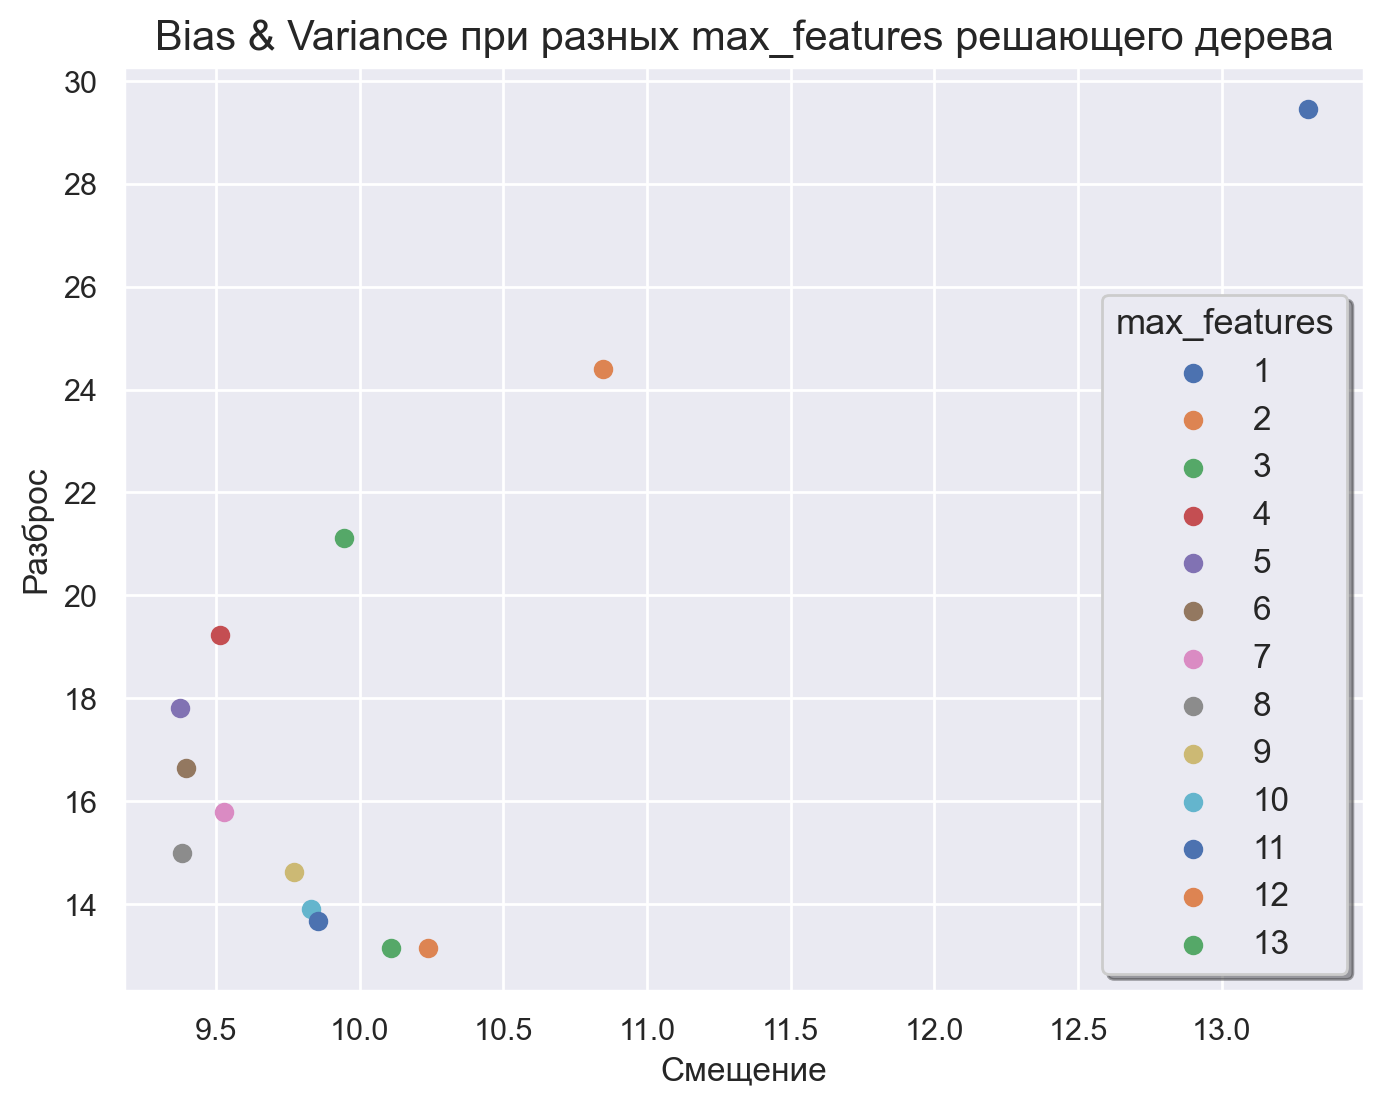

In [36]:
# тестим max_features
plt.figure(figsize=(8, 6))

for max_features in range(1, X.shape[1]+1):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_features=max_features), X, y)
    plt.scatter(bias, variance, label = str(max_features), cmap=sns.color_palette("viridis", as_cmap=True))

plt.legend(title='max_features', title_fontsize=13, fontsize=12, loc='best', shadow=True)
plt.xlabel('Bias')
plt.ylabel('Variance')
plt.title('Bias & Variance при разных max_features решающего дерева', fontsize=15);

Здесь некоторые цвета одинаковые, т.к. в дискретной палитре всего 10 цветов, но, понятно, что значения 1, 2, 3 находятся в верхнем правом углу.

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

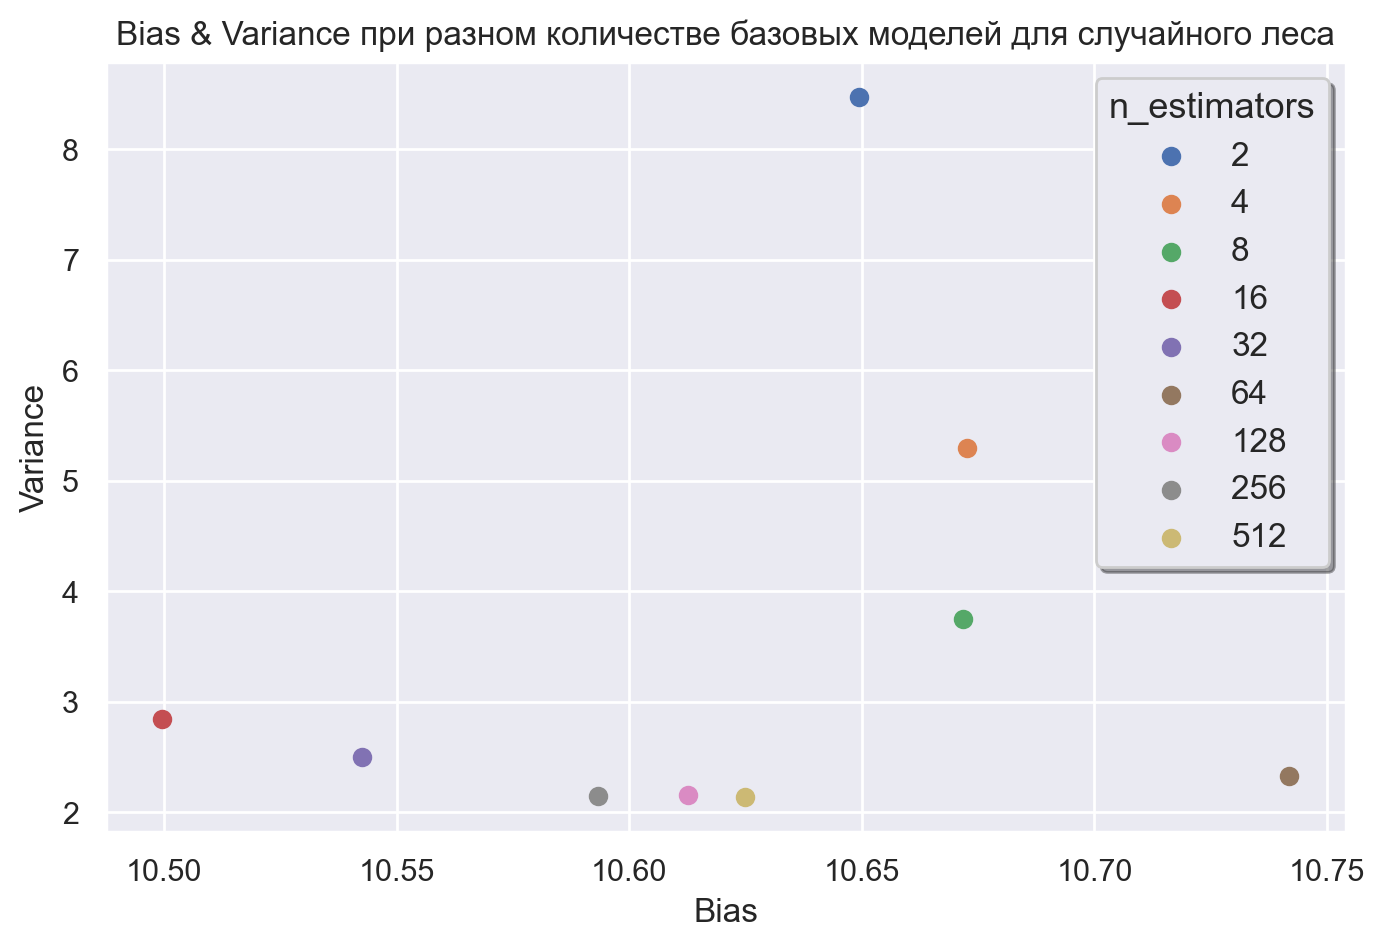

In [40]:
# тестим n_estimators для случайного леса
plt.figure(figsize=(8, 5))

for n_estimators in (2**np.arange(1, 10)):
    bias, variance, _ = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators), X, y)
    plt.scatter(bias, variance, label=str(n_estimators), cmap=sns.color_palette("Spectral", as_cmap=True))

plt.legend(title='n_estimators', title_fontsize=13, fontsize=12, loc='best', shadow=True)
plt.xlabel('Bias')
plt.ylabel('Variance')
plt.title('Bias & Variance при разном количестве базовых моделей для случайного леса', fontsize=15);

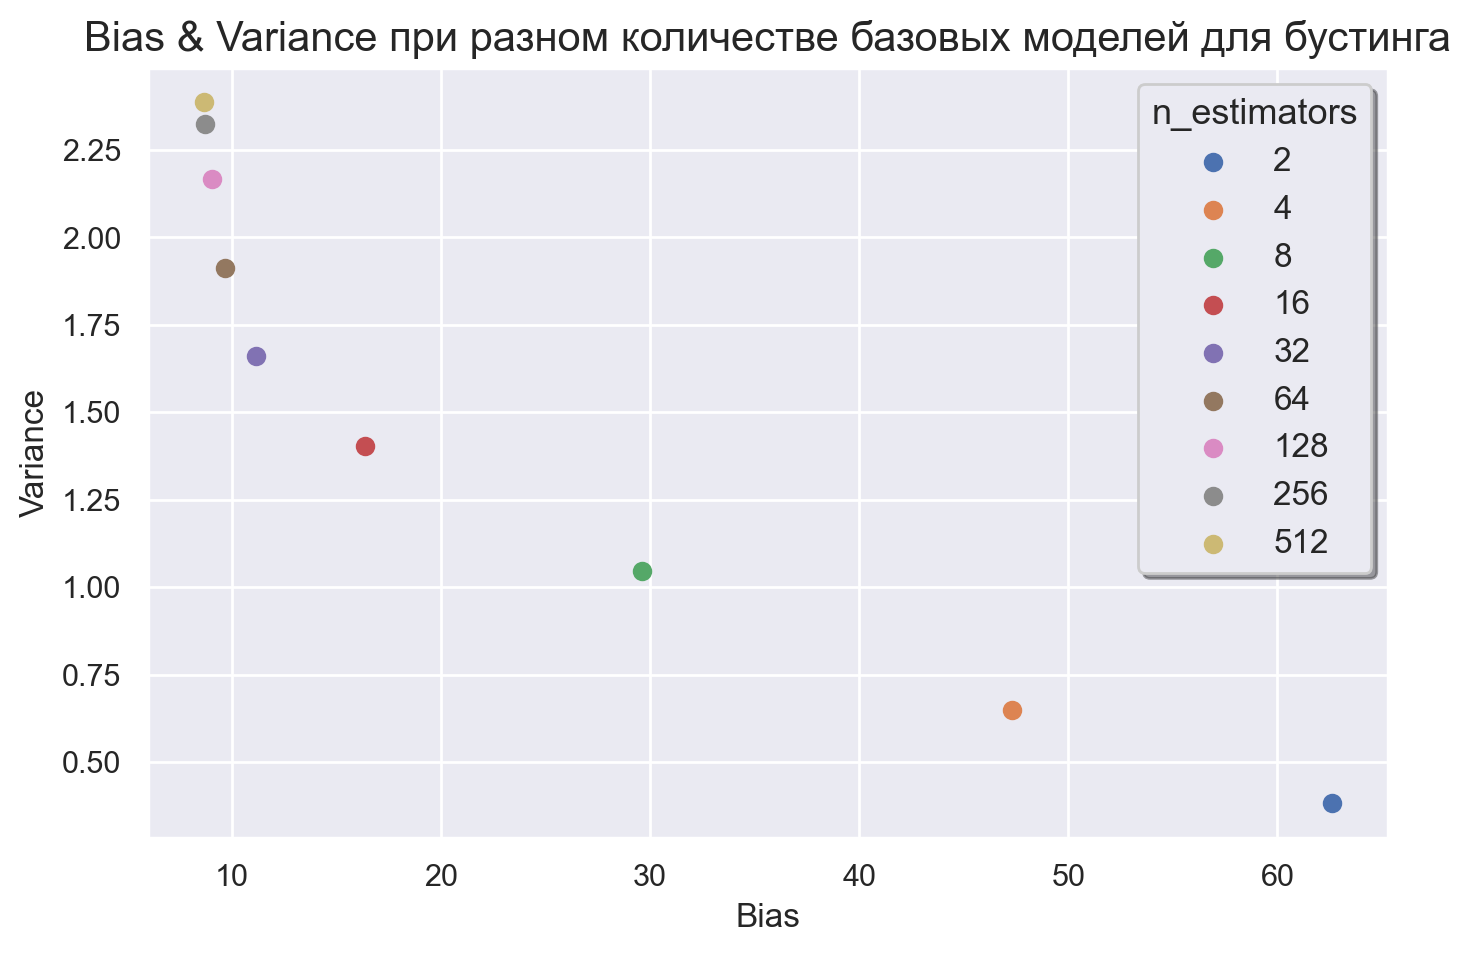

In [41]:
# тестим n_estimators для градиентного бустинга
plt.figure(figsize=(8, 5))

for n_estimators in (2**np.arange(1, 10)):
    bias, variance, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators), X, y)
    plt.scatter(bias, variance, label=str(n_estimators), cmap=sns.color_palette("Spectral", as_cmap=True))

plt.legend(title='n_estimators', title_fontsize=13, fontsize=12, loc='best', shadow=True)
plt.xlabel('Bias')
plt.ylabel('Variance')
plt.title('Bias & Variance при разном количестве базовых моделей для бустинга', fontsize=15);

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 

1 график (перебор `max_depth` для **реш. дер.**): 
* видно, что в, зависимости от глубины, у дерева может сильно меняться как смещение, так и разброс;
* хорошо заметно, что решающий пень (глубина = 1) - плохая история, дерево сильно неточное (недообучается), и его шатает;
* в целом, видно, что, чем больше глубина дерева, тем сильнее оно переобучается: если бы не отметка для глубины 3, можно было бы провести монотонно возрастающую по variance кривую;
    * в целом, оптмиальной глубиной для одного дерева можно назвать значения 4, 5 и 6.

2 график (перебор `max_features` для **реш. дер.**):
* смещение уже меньше зависит от `max_features`, а вот разброс - в большей степени (видимо, заставляем дерево переобучаться, оставляя не так много признаков для выбора), поэтому настройкой этого гиперпараметра мы прежде всего влияем на разброс модели;
* очевидно плохой вариант - брать очень мало признаков для выбора - дерево недообучается;
* если брать все или почти все признаки - получается большое смещение (вероятно, модель переобучается);
* самым оптимальным значением кажется 8 или 9-11, если мы готовы пожертвовать смещением.

3 график (переборо `n_estimators` для **случайного леса**): 
* на лекции было сказано, что случайный лес не переобучается при увеличении `n_estimators` - и это заметно: во-первых, нет связи между числом базовых моделей и смещением, во-вторых, интервал, в котором изменяется смещение на графике, минимален: около 0.25
    * значит, в этом случае мы снова влияем на разброс этим гиперпараметром;
* в контексте случайного леса предпочтительнее при прочих равных выбирать меньшее число деревьев, т.к. он очень долго учится;
* очевидно, для случайного леса нужно брать, как минимум, 16 моделей, согласно графику, чтобы композиция получилась сильной;
* по разбросу и смещению оптимальным будет взять 256 моделей, но, если данные не очень сложные, я бы выбрал 32, поскольку тогда лес будет учиться гораздо быстрее.

4 график (переборо `n_estimators` для **градиентного бустинга**):
* помним, что бустинг уже можно переобучить с ростом числа базовых моделей: здесь уже явная монотонно возрастающая кривая по variance в зависимости от числа моделей. Но, хотя бустинг и переобучается, это не насколько кардинадьно влияет на его разброс, как у предыдущих моделей (максимально смещение около 2.3);
* с помощью `n_estimators` для бустинга можно настроить как смещение, так и разброс (хотя смещение в большей степени);
* опять же, это тоже композиция и брать маленькое число моделей (< 16) нерационально;
* думаю, что оптимальным числом моделей в данном случае было бы около 64.

Дальше я хотел бы сравнить все получившиеся оптимальные модели:

In [45]:
# оптимальное дерево
np.random.seed(13)
bias, variance, loss = compute_biase_variance(DecisionTreeRegressor(
    max_depth=6,
    max_features=8
), X, y)

print(f'Bias = {bias}, \nVariance = {variance}, \nLoss = {loss}')

Bias = 10.711134416471083, 
Variance = 13.010925236516071, 
Loss = 23.811744755791295


Если напрямую сравнить опробованные модели с оптимальными гиперпараметрами, получится примерно следующее (для лин. рег. не подбирали):

* *линейная регрессия*: Bias = 23.7, Variance = 1.0
* *решающее дерево*: Bias $\approx$ 10, Variance $\approx$ 13
* *случайный лес*: Bias $\approx$ 10.6, Variance $\approx$ 2.1
* *градиентный бустинг*: Bias $\approx$ 9.9, Variance $\approx$ 1.9

Выходит, бустинг от sklearn всех сделал :)

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

Я начал зиму решением домашек по МО в своей любимой кофейне под домом - ходить дальше я пока что не могу)

<img src="https://www.dropbox.com/s/20jaqt4uo3kbw7j/photo4.jpg?dl=1" align="center" width="30%" style="margin-left: 20px; margin-bottom: 20px">
<img src="https://www.dropbox.com/s/rs3dqfw0zb2m4ub/photo5.jpg?dl=1" align="center" width="30%" style="margin-left: 20px; margin-bottom: 20px">